In [1]:
!pip3 install pystan prophet

In [7]:
import pandas as pd
from prophet import Prophet

In [3]:
df = pd.read_csv('dataset.csv')

In [4]:
print(df['Product'].unique())
print(df['Store'].unique())

[2667437]
['QLD_CW_ST0203']


In [5]:
df['Year'] = df['Time Date'].apply(lambda x: str(x)[-4:])
df['Month'] = df['Time Date'].apply(lambda x: str(x)[-6:-4])
df['Day'] = df['Time Date'].apply(lambda x: str(x)[:-6])
df['ds'] = pd.DatetimeIndex(df['Year'] + '-' + df['Month'] + '-' + df['Day'])
df.dtypes

Time Date             int64
Product               int64
Store                object
Value               float64
Year                 object
Month                object
Day                  object
ds           datetime64[ns]
dtype: object

In [6]:
df.drop(['Time Date', 'Product', 'Store', 'Year', 'Month', 'Day'], axis=1, inplace=True)
df.columns = ['y', 'ds']

# Training

## 1.  Uncertainty

- `interval_width=0.95` -> handles trend uncertainty (as opposed to uncertainty in seasonality)
    - by allowing higher flexibility rate, `changepoint_prior_scale`, we also increase the forecast uncertainty
    - This is because if we model more rate changes in the history then we will expect more in the future, and makes the uncertainty intervals a useful indicator of overfitting
    

- Uncertainty in seasonality: to get uncertainty in seasonality, you must do full Bayesian sampling:
    - `m = Prophet(mcmc_samples=300)`
    - This replaces the typical MAP estimation with MCMC sampling

In [13]:
m = Prophet(interval_width=0.95, daily_seasonality=True)
m.fit(df)

Initial log joint probability = -33.1653


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1946.15    0.00154934       81.6896      0.8003      0.8003      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       1946.18   0.000238115       88.2856   2.661e-06       0.001      161  LS failed, Hessian reset 
     199       1946.24   0.000566946       86.8058           1           1      291   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     207       1946.38   0.000696341       83.5831   7.989e-06       0.001      344  LS failed, Hessian reset 
     299       1946.44   2.57067e-05       89.0436     0.02439      0.2163      474   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     366       1946.45   5.77081e-06       56.0772   1.023e-07       0.001      607  LS failed, Hessian reset 
     399       1946.45   2.19949e-07  

## Forecast

In [32]:
future = m.make_future_dataframe(periods=365,freq='D')
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-01,3069.710769,1554.019277,3531.886060,3069.710769,3069.710769,-510.075981,-510.075981,-510.075981,649.010487,...,16.217922,16.217922,16.217922,-1175.304390,-1175.304390,-1175.304390,0.0,0.0,0.0,2559.634788
1,2018-01-02,3068.698988,1533.390239,3604.632660,3068.698988,3068.698988,-523.790909,-523.790909,-523.790909,649.010487,...,-11.516471,-11.516471,-11.516471,-1161.284925,-1161.284925,-1161.284925,0.0,0.0,0.0,2544.908079
2,2018-01-03,3067.687206,1552.483571,3611.326769,3067.687206,3067.687206,-501.398219,-501.398219,-501.398219,649.010487,...,-4.475679,-4.475679,-4.475679,-1145.933026,-1145.933026,-1145.933026,0.0,0.0,0.0,2566.288988
3,2018-01-04,3066.675425,1641.827545,3672.314809,3066.675425,3066.675425,-457.764419,-457.764419,-457.764419,649.010487,...,22.514425,22.514425,22.514425,-1129.289331,-1129.289331,-1129.289331,0.0,0.0,0.0,2608.911006
4,2018-01-05,3065.663643,1555.319662,3623.101335,3065.663643,3065.663643,-496.816695,-496.816695,-496.816695,649.010487,...,-34.377077,-34.377077,-34.377077,-1111.450105,-1111.450105,-1111.450105,0.0,0.0,0.0,2568.846948


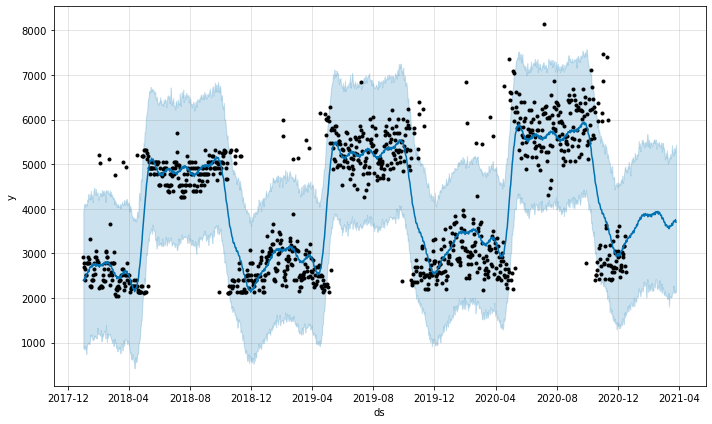

In [19]:
plot1 = m.plot(forecast)

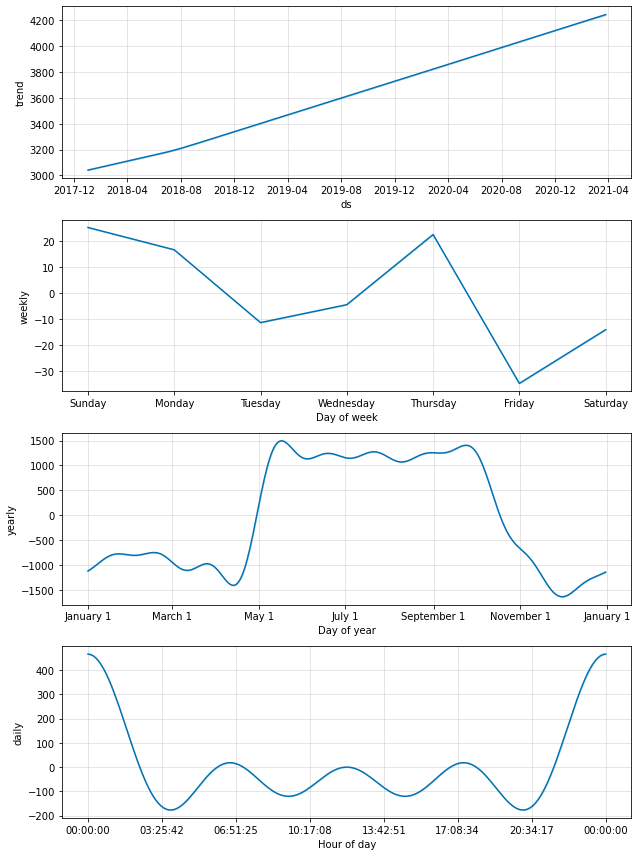

In [20]:
# Seasonality by timeframe
plt2 = m.plot_components(forecast)

# 2. Trend changepoints

Changepoints: abrupt changes in timeseries trajectory. By default, Prophet will automatically detect these changepoints and will allow the trend to adapt appropriately. 

However, if you wish to have finer control over this process (e.g., Prophet missed a rate change, or is overfitting rate changes in the history):

`m = Prophet(changepoint_range=0.9)` - Changepoints are only inferred for the first 90% of the time series. Default is 80% (in order to have plenty of runway for projecting the trend forward and to avoid overfitting fluctuations at the end of the time series).

`m = Prophet(changepoint_prior_scale=0.5)` - default is 0.05. Adjusting the strength of the sparse prior if the model is overfitting (too much flexibility) or underfitting (not enough flexibility).

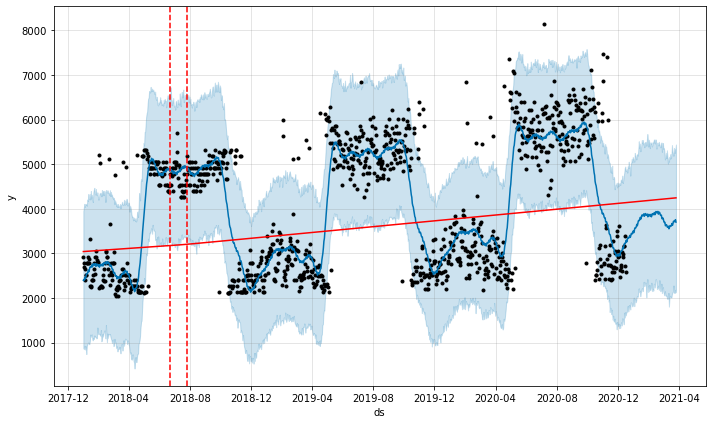

In [21]:
from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)


## 2.1 Adjusting changepoint range

Initial log joint probability = -33.1653
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1946.14   0.000244114       86.5531           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1946.35    4.5714e-06       63.0264           1           1      261   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220       1946.35   9.67108e-08        53.485      0.2631           1      292   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


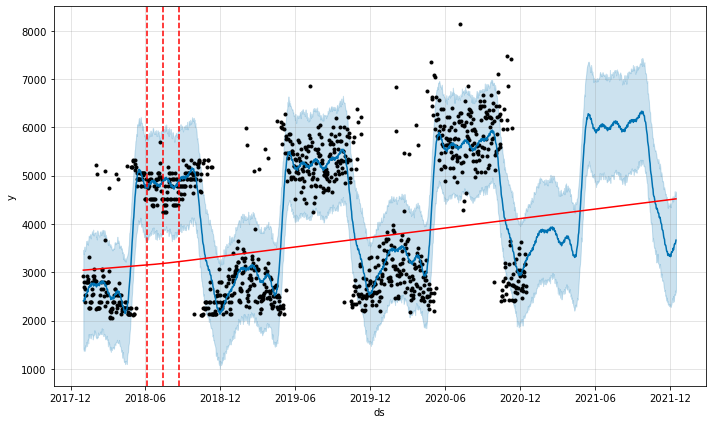

In [38]:
m = Prophet(changepoint_range=0.9, daily_seasonality=True)
m.fit(df)
forecast = m.predict(future)
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

Initial log joint probability = -33.1653
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      93       1946.03   0.000244054        122.83   1.568e-06       0.001      170  LS failed, Hessian reset 
      99       1946.11   0.000167674        62.497      0.9214      0.9214      176   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     178       1946.23   0.000611931       202.886   5.023e-06       0.001      320  LS failed, Hessian reset 
     199       1946.31   6.20672e-06       73.4458           1           1      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     250       1946.31   8.68134e-06       92.4543   1.124e-07       0.001      453  LS failed, Hessian reset 
     263       1946.31   1.73275e-08       68.4111     0.04023           1      478   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

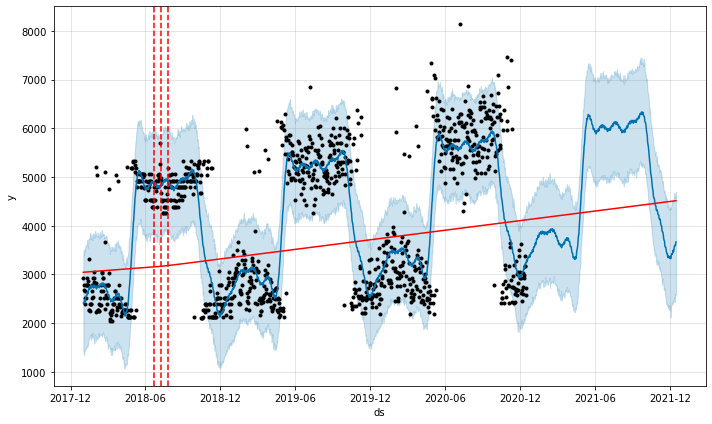

In [37]:
m = Prophet(changepoint_range=0.4, daily_seasonality=True)
m.fit(df)
forecast = m.predict(future)
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

## 2.2 Adjusting trend flexibility (_changepoint_prior_scale_)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -33.1653
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      62       1903.65   1.95381e-05       4888.95   4.006e-09       0.001      120  LS failed, Hessian reset 
      99       1903.72   1.71229e-08        5037.8           1           1      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       1903.72   5.98432e-09       4905.65      0.6761      0.6761      167   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


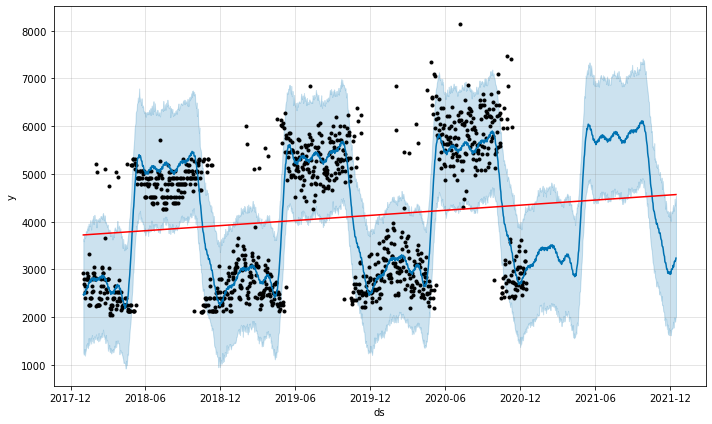

In [35]:
m = Prophet(changepoint_prior_scale=0.001)
m.fit(df)
forecast = m.predict(future)
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -33.1653
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1948.68   0.000940529       14.4398      0.4958      0.4958      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1948.87   0.000182011       8.07373           1           1      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1948.93   9.49312e-05       5.56205        1.43       0.143      389   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     356       1948.97   0.000657992       28.0675   9.685e-05       0.001      495  LS failed, Hessian reset 
     399       1948.98   1.72281e-05       7.17165      0.5558      0.5558      552   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     422       1948.98   8.20124e-07    

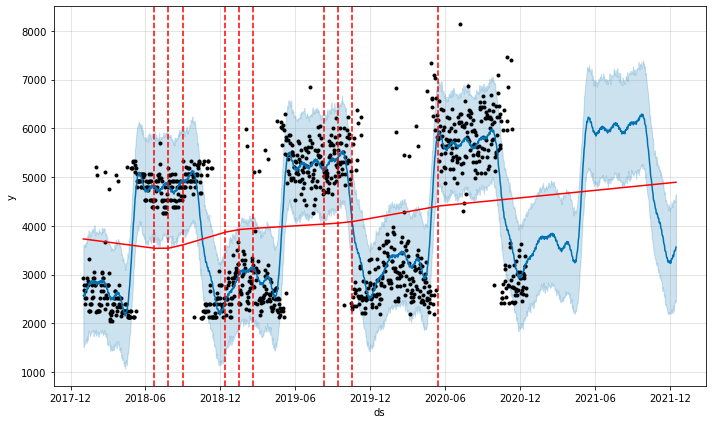

In [36]:
m = Prophet(changepoint_prior_scale=0.5)
m.fit(df)
forecast = m.predict(future)
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)